In [ ]:
#!pip3 install numpy==1.20.0
!pip3 install sentence_transformers
!pip3 install umap-learn
!pip3 install hdbscan --no-cache-dir --no-binary :all: --no-build-isolation
#!pip3 install scikit-learn
#!pip3 install pandas
#!pip3 install matplotlib

#pip install --upgrade pip setuptools wheel
#pip install bertopic --no-cache-dir
#pip uninstall hdbscan -y
#pip install hdbscan --no-cache-dir --no-binary :all: --no-build-isolation
#!pip3 install sklearn

In [2]:
import os
from google.colab import drive
drive.mount('drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

Mounted at drive


In [28]:
import pandas as pd
from sklearn.utils import shuffle

df=pd.read_csv('data/test_data_result.csv')
#df=pd.read_csv('data/inference_data_result.csv')

df.head()
topic_list = df.columns[2:]

In [29]:
'''
df=df.drop(['Unnamed: 0'
            #,'Unnamed: 0.1'
           ], axis=1)
df=df[df['full_text'].notna()]
'''
#If we were to take only half
#df = shuffle(df)
#df=df[0:int(len(df)/2)]

'''
df=df.reset_index(drop=True)
display(df.head())
'''

'\ndf=df.reset_index(drop=True)\ndisplay(df.head())\n'

In [30]:
from sentence_transformers import SentenceTransformer

model_distil = SentenceTransformer('distilbert-base-nli-mean-tokens')
model = SentenceTransformer('bert-large-nli-mean-tokens')

In [31]:
#df_full = df[df['full_text'].notna()]
df_full = df[df['comment_text'].notna()]
data=df_full['comment_text'].tolist()
print(len(data))
data_select = data

21630


In [32]:
init_cluster = []
for i in range(len(data)):
  curr_row = list(df_full.iloc[i,2:].values)
  try:
    init_cluster.append(topic_list[curr_row.index(1)])
  except: 
    init_cluster.append('None')
init_cluster_df = pd.DataFrame(data = {'uid':df_full.id.values, 'init_topic':init_cluster})
init_cluster_df

,uid,init_topic
0,246862,biden
1,419761,antiimmigrant
2,276730,biden
3,402936,None
4,173415,voterfraud
...,...,...
21625,147124,biden
21626,247680,biden
21627,252087,None
21628,193107,biden


In [33]:
embeddings = model.encode(data_select, show_progress_bar=True)

Batches:   0%|          | 0/676 [00:00<?, ?it/s]

In [34]:
embedding_diistil = model_distil.encode(data_select, show_progress_bar=True)

Batches:   0%|          | 0/676 [00:00<?, ?it/s]

### Dimension Reduction with UMAP

In [35]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=5, # local neighborhood
              n_components=50, # dimension
              metric='cosine').fit_transform(embeddings)

In [36]:
print(type(umap_embeddings))
print(umap_embeddings[0])
len(umap_embeddings)

<class 'numpy.ndarray'>
[1.8360118 5.555416  3.7216318 2.7965696 5.1788416 7.6975913 1.1669402
 4.961305  6.029223  5.9749556 5.2800746 4.234313  3.720886  3.569502
 4.687771  4.331612  6.3314686 6.344632  1.8526669 4.882493  4.979642
 4.9961634 4.031763  5.5209517 4.3205547 4.7796264 5.6238694 4.023513
 2.980316  7.584644  5.1541677 1.0598133 1.5596619 2.0520318 8.002602
 5.0166855 5.8138027 6.515288  5.1139    2.5760174 4.669116  3.433339
 2.989477  6.9863534 4.564564  4.304389  4.901848  5.7382455 3.582727
 5.1314135]


21630

### Cluster the documents with HDBSCAN


In [37]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                          #min_samples=40,
                          metric='euclidean', 
                          #cluster_selection_epsilon = 1,
                          cluster_selection_method='eom').fit(umap_embeddings)

In [38]:
docs_df = pd.DataFrame(data_select, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df.to_csv('docs_df.csv')
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic.to_csv('docs_per_topic.csv')
docs_per_topic

,Topic,Doc
0,-1,wee hour thanksgiving day a mista d project th...
1,0,email purport hunter biden abandon laptop veri...
2,1,update immigration customs enforcement ice age...
3,2,vote close donald trump could easily throw ele...
4,3,quick note tech giant shut u know twitter link...
5,4,immigration customs enforcement ice agency qui...
6,5,electronic voting machine see polling station ...
7,6,flurry executive order sign first day presiden...
8,7,massive soda company coca-cola face challenge ...
9,8,9th circuit court appeals friday rule presiden...


In [39]:
print(len(docs_per_topic))
docs_per_topic=docs_per_topic[docs_per_topic['Topic']!=-1] 
docs_per_topic=docs_per_topic.reset_index(drop=True)
print(len(docs_per_topic))
docs_per_topic=docs_per_topic[docs_per_topic['Doc'].str.contains("[a-zA-Z]").fillna(False)]
print(len(docs_per_topic))

23
22
22


In [40]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#np.seterr(divide='ignore', invalid='ignore')

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    
    w = t.sum(axis=1)

    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

### Topic Representation
In order to create a topic representation, we take the top 5 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.


In [41]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.to_csv('topic_sizes.csv')
topic_sizes.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,10120
20,19,7283
16,15,1266
17,16,690
11,10,369
22,21,336
8,7,174
19,18,168
18,17,168
13,12,127


In [42]:
top_topic_labels = topic_sizes.Topic[:11].values
top_topic_labels

array([-1, 19, 15, 16, 10, 21,  7, 18, 17, 12, 11])

In [43]:
topic_sizes['topic top words']=topic_sizes['Topic'].map(top_n_words)

def word_extract(x):
    if type(x)!= float:
        z=[tup[0] for tup in x]
    else: z=1
    return z

topic_sizes['words']=topic_sizes['topic top words'].apply(lambda x:word_extract(x))
topic_sizes=topic_sizes[topic_sizes['words']!=1]
topic_sizes.head(20)

,Topic,Size,topic top words,words
20,19,7283,"[(capitol, 0.002048272330537723), (police, 0.0...","[capitol, police, georgia, black, violence, of..."
16,15,1266,"[(amp, 0.009073168660010162), (vaccine, 0.0071...","[amp, vaccine, virus, china, covid, coronaviru..."
17,16,690,"[(tax, 0.009371497445794574), (relief, 0.00487...","[tax, relief, payment, billion, stimulus, tril..."
11,10,369,"[(border, 0.025630743810525165), (migrant, 0.0...","[border, migrant, mexico, immigration, facilit..."
22,21,336,"[(abortion, 0.019236527668577412), (transgende...","[abortion, transgender, gender, woman, sex, gi..."
8,7,174,"[(pipeline, 0.02599204566329438), (oil, 0.0197...","[pipeline, oil, climate, keystone, xl, energy,..."
19,18,168,"[(hunter, 0.02400157839433336), (laptop, 0.020...","[hunter, laptop, fbi, isaac, computer, russian..."
18,17,168,"[(oilfield, 0.013236992974366611), (county, 0....","[oilfield, county, total, nevada, ran, navarro..."
13,12,127,"[(school, 0.019710109268411817), (student, 0.0...","[school, student, curriculum, teacher, racism,..."
12,11,97,"[(gun, 0.04883748442865941), (firearm, 0.02387...","[gun, firearm, weapon, background, rifle, pist..."


In [44]:
topic_sizes_reset = topic_sizes.reset_index()
top_words = []
for i in range(len(topic_sizes)):
  #print(topic_sizes_reset.words[i][:5])
  curr_top_words = ', '.join(topic_sizes_reset.words[i][:5])
  top_words.append(curr_top_words)

top_words_df = pd.DataFrame(data={'Topic':topic_sizes.Topic, 'Size':topic_sizes.Size, 'top_five_words':top_words})

In [45]:
top_words_df_idx = top_words_df.reset_index(drop=True).reset_index()
top_words_df_idx

,index,Topic,Size,top_five_words
0,0,19,7283,"capitol, police, georgia, black, violence"
1,1,15,1266,"amp, vaccine, virus, china, covid"
2,2,16,690,"tax, relief, payment, billion, stimulus"
3,3,10,369,"border, migrant, mexico, immigration, facility"
4,4,21,336,"abortion, transgender, gender, woman, sex"
5,5,7,174,"pipeline, oil, climate, keystone, xl"
6,6,18,168,"hunter, laptop, fbi, isaac, computer"
7,7,17,168,"oilfield, county, total, nevada, ran"
8,8,12,127,"school, student, curriculum, teacher, racism"
9,9,11,97,"gun, firearm, weapon, background, rifle"


(0.0, 8.5)

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


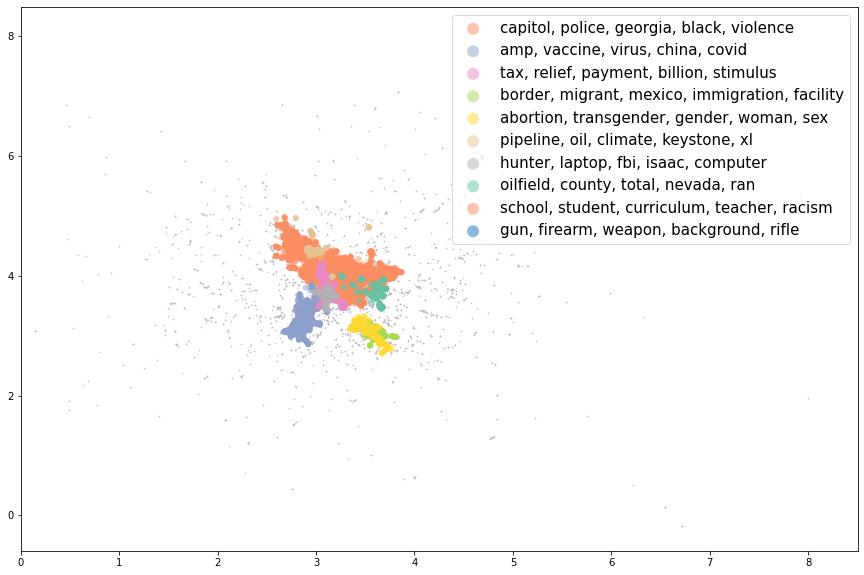

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Prepare data
#umap_data = umap.UMAP(n_neighbors=5, n_components=23, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings[:,:2], columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
outliers = result.loc[result.labels == -1, :]
small_cluster = result.loc[~result.labels.isin(top_topic_labels), :]
clustered = result.loc[result.labels.isin(top_topic_labels), :]
clustered = clustered.merge(top_words_df, left_on = 'labels', right_on='Topic')

rgb_values = sns.color_palette("Set2", 10)

# Map continents to the colors
color_map = dict(zip(top_topic_labels, rgb_values))

#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
#plt.scatter(clustered.x, clustered.y, c=clustered['Topic'].map(color_map), s=0.05, cmap='hsv_r')

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
#ax.scatter([math.log(a+5) for a in list(outliers.x.values)], [math.log(a) for a in list(outliers.y.values)], color='#BDBDBD', s=0.05)

ax.scatter(small_cluster.x, small_cluster.y, color='#BDBDBD', s=0.05)
#ax.scatter([math.log(a+5) for a in list(small_cluster.x.values)], [math.log(a) for a in list(small_cluster.y.values)], color='#BDBDBD', s=0.05)

for t in top_words_df_idx.Topic.values[:10]:
  subset = clustered.loc[clustered.Topic == t,:]
  ax.scatter(#[math.log(a+5) for a in list(subset.x.values)], [math.log(a) for a in list(subset.y.values)],
             subset.x, subset.y, 
             c=subset['Topic'].map(color_map), 
             label=top_words_df.top_five_words.values[top_words_df.Topic == t][0],
              alpha=0.5, edgecolors='none')

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels,  markerscale=2., framealpha = 0.7, loc='upper right', prop={'size': 15})
#ax.set_xlim(8,9.5)
#ax.set_ylim(4.5,5.6)
ax.set_xlim(0,8.5)

#plt.show()
#plt.legend(rgb_values, clustered.Topic.unique())

(0.0, 8.5)

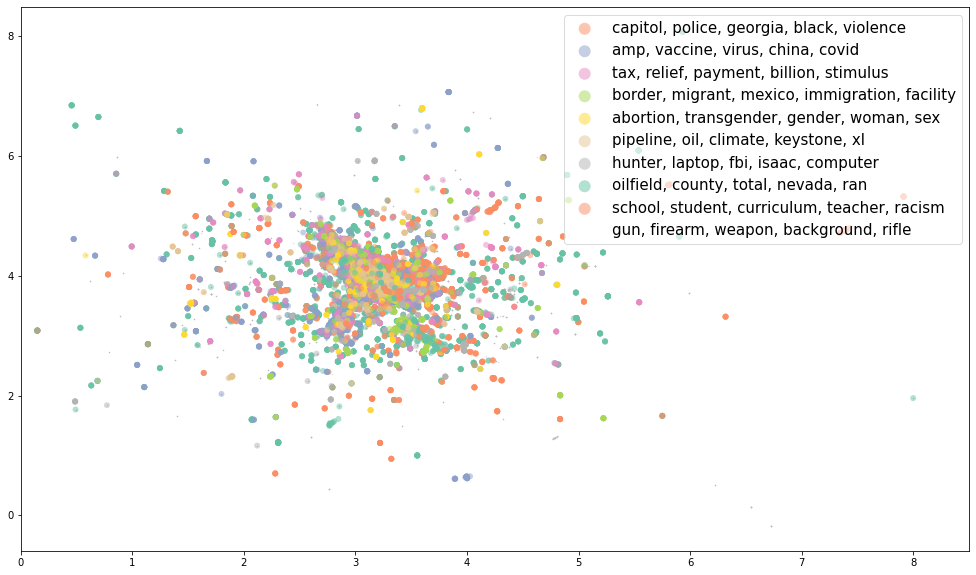

In [50]:
import collections
occurrences = collections.Counter(init_cluster)
top_topics = occurrences.most_common()
top_topics = [x for (x,y) in top_topics]
top_topics.remove('None')
top_10_topics = top_topics[:10]

result['init_topic'] = init_cluster

#outliers_init = result.loc[init_cluster == 'None', :]
small_cluster_init = result.loc[~init_cluster_df.init_topic.isin(top_10_topics), :]
clustered_init = result.loc[init_cluster_df.init_topic.isin(top_10_topics), :]
#clustered_init = clustered_init.merge(top_words_df, left_on = 'labels', right_on='Topic')

# Map continents to the colors
color_map_init = dict(zip(top_10_topics, rgb_values))

#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
#plt.scatter(clustered.x, clustered.y, c=clustered['Topic'].map(color_map), s=0.05, cmap='hsv_r')

fig, ax = plt.subplots(figsize=(17, 10))
#ax.scatter(outliers_init.x, outliers_init.y, color='#BDBDBD', s=0.05)
ax.scatter(small_cluster_init.x, small_cluster_init.y, color='#BDBDBD', s=0.05)
for t in top_10_topics:
  #print(t)
  subset = clustered_init.loc[init_cluster_df.init_topic == t,:]
  #print(subset)
  ax.scatter(subset.x, subset.y, c=subset['init_topic'].map(color_map_init), 
             label=t,
            alpha=0.5, edgecolors='none')
ax.legend(handles, labels,  markerscale=2., framealpha = 0.7, loc='upper right', prop={'size': 15})
#ax.set_xlim(8,9.5)
#ax.set_ylim(4.5,5.6)
ax.set_xlim(0,8.5)
